In [1]:
import random
import matplotlib.pyplot as plt
import warnings
import numpy as np

warnings.filterwarnings("ignore")
rs = np.random.RandomState(0)
% matplotlib inline
% config InlineBackend.figure_format = 'svg'
import matplotlib;matplotlib.rcParams['font.size'] = 16
import matplotlib;matplotlib.rcParams['font.family'] = 'serif'
from visualize import *
from calibration import *
from active_learning import *
from collections import defaultdict
from tqdm import tqdm
from spline import *
import collections


NUM_BINS = 10
NUM_CLASSES =  100
NUM_CLASSES_PLOT = 4
NUM_COL = 5
NUM_RUN = 50
# limit to the cases when the number of samples is less than 1000
NUM_SAMPLES = [20, 30, 40, 50, 60, 70, 80, 90, 100] + [50 * _ for _ in range(3, 19)] 
print len(NUM_SAMPLES) # should not exceed 25 because the number of subplots is set to be 25.
METHOD_NAME = "binary_spline"

25
25


try out the PyGAM package (e.g., Logistic GAM with splines) for one or more of our datasets (e.g., p(y=1 | max_k s_k(x)) for calibration, or Accuracy( g (x) ) versus g(x) where g(x) is brightness - to get a sense whether this approach is a bit more robust than (say) GP classification methods.

In [2]:
# # Load prediction from ResNet on CIFAR100 test data, which contains 10,000 images. 
# # https://github.com/rloganiv/pytorch-classification/blob/master/predict.py
# # data: a numpy array of size 10,000 * 101. For each row, the first entry is the true label,
# #       following by softmax of output logits of this image for each class.
# # DATASET = "cifar100/cifar100_predictions_dropout"
# DATASET = "cifar100_predictions_dropout"
# data = np.genfromtxt("data/cifar100/%s.txt" % DATASET)# 10000*101
# N = data.shape[0]
# score = data[:,1:]
# Y_predict = np.argmax(score, axis=1)
# Y_true = data[:,0]
# print "ACC=%.4f" % ((Y_predict == Y_true).sum() * 1.0/ N)


DATASET = "svhn_predictions"
data = np.genfromtxt("data/svhn/%s.txt" % DATASET)# 10000*101
N = data.shape[0]
score = data[:,1:]
Y_predict = np.argmax(score, axis=1)
Y_true = data[:,0]


# DATASET = "cifar100_adversarial_predictions"
# data = np.genfromtxt("data/cifar100_adversarial/%s.txt" % DATASET)# 10000*101
# N = data.shape[0]
# score = data[:,1:]
# Y_predict = np.argmax(score, axis=1)
# Y_true = data[:,0]
# print "ACC=%.4f" % ((Y_predict == Y_true).sum() * 1.0/ N)

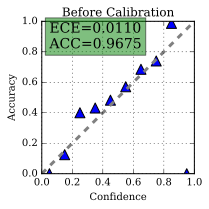

In [3]:
fig, ax = plt.subplots()
fig.set_figheight(3)
fig.set_figwidth(3)
ece, acc, ax = reliability_plot(ax, score, Y_true, NUM_BINS)
ax.set_title("Before Calibration")
fig.tight_layout()

In [ ]:
# train a Spline regression model using all available data points as a reference model.
# MSE between this spline curve and the one trained on selected datapoints will be computed as a metric for evaluation.
gam_ref = LogisticGAM(s(0, constraints='monotonic_inc')).gridsearch(
                    np.max(score, axis=1).reshape(-1, 1),
                    np.array(Y_true == Y_predict) * 1) # add a linear term

100% (11 of 11) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


In [ ]:
# feed all data into spline regression
fig, ax = plt.subplots()
fig.set_figheight(2)
fig.set_figwidth(2)
ece, acc, mse, ax, confi = spline_classification_plot(ax,
                           np.max(score, axis=1).reshape(-1, 1),
                           np.array(Y_true == Y_predict) * 1,
                           np.max(score, axis=1).reshape(-1, 1),
                           np.array(Y_true == Y_predict) * 1,
                           gam_ref)
fig.tight_layout()

 54% (6 of 11) |#############            | Elapsed Time: 0:00:03 ETA:   0:00:02

# active learning

In [ ]:
training_list = [i for i in range(N)]
subset_init = np.random.choice(training_list, size = NUM_SAMPLES[0], replace = False).tolist()

### randomly select datapoints and feed to spline regression

In [ ]:
ece_random_emp, acc_random_emp, mse_random_emp, subset_random_emp = active_learning_plot(
    score, Y_predict, Y_true, acq_random_emp, subset_init, training_list, NUM_SAMPLES, gam_ref)

In [ ]:
ece_random_unf, acc_random_unf, mse_random_unf, subset_random_unf = active_learning_plot(
    score, Y_predict, Y_true, acq_random_unf, subset_init, training_list, NUM_SAMPLES, gam_ref)

### actively select datapoints and feed into spline regression

In [ ]:
# reweight datapoints acccording to uncertainty
ece_active_prb, acc_active_prb, mse_active_prb, subset_active_prb = active_learning_plot(
    score, Y_predict, Y_true, acq_active_prb, subset_init, training_list, NUM_SAMPLES, gam_ref)

In [ ]:
## select data points with highest uncertainty
ece_active_dtm, acc_active_dtm, mse_active_dtm,  subset_active_dtm = active_learning_plot(
    score, Y_predict, Y_true, acq_active_dtm, subset_init, training_list, NUM_SAMPLES, gam_ref)

### Compare different acquisition methods in a single run

In [ ]:
plot_metric_single_run(ece_random_emp, acc_random_emp, mse_random_emp,\
                          ece_random_unf, acc_random_unf, mse_random_unf,\
                          ece_active_prb, acc_active_prb, mse_active_prb,\
                          ece_active_dtm, acc_active_dtm, mse_active_dtm, NUM_SAMPLES)

In [ ]:
# compare the histogram of scores of datapoints selected with different methods
fig, ax = plt.subplots(nrows=1, ncols=4, sharey = True)
fig.set_figheight(2.5)
fig.set_figwidth(10)
ax[0].hist(np.max(score, axis=1).reshape(-1, 1)[subset_random_emp])
ax[0].set_xlim(0.0, 1.0)
ax[0].set_title("Random_Emp")
ax[1].hist(np.max(score, axis=1).reshape(-1, 1)[subset_random_unf])
ax[1].set_xlim(0.0, 1.0)
ax[1].set_title("Random_Unf")
ax[2].hist(np.max(score, axis=1).reshape(-1, 1)[subset_active_prb])
ax[2].set_xlim(0.0, 1.0)
ax[2].set_title("Active_Prb")
ax[3].hist(np.max(score, axis=1).reshape(-1, 1)[subset_active_dtm])
ax[3].set_xlim(0.0, 1.0)
ax[3].set_title("Active_Dtm")

## Multiple runs to get errorbars

In [ ]:
######### run spline_run.py for a given dataset for multiple runs.
# results will be written to output/DATASET with filenames ece_random.csv, 
# ece_active.csv, acc_random.csv, acc_active.csv.

# disij@datalab-5 22:19:44 ~/projects/sandbox/nn_assessor
# python spline_run.py

ece_random_emp_multi_run = LoadCsvFromOutput("output/%s/ece_random_emp.csv" % DATASET)
acc_random_emp_multi_run = LoadCsvFromOutput("output/%s/acc_random_emp.csv" % DATASET)
mse_random_emp_multi_run = LoadCsvFromOutput("output/%s/mse_random_emp.csv" % DATASET)
ece_random_unf_multi_run = LoadCsvFromOutput("output/%s/ece_random_unf.csv" % DATASET)
acc_random_unf_multi_run = LoadCsvFromOutput("output/%s/acc_random_unf.csv" % DATASET)
mse_random_unf_multi_run = LoadCsvFromOutput("output/%s/mse_random_unf.csv" % DATASET)
ece_active_prb_multi_run = LoadCsvFromOutput("output/%s/ece_active_prb.csv" % DATASET)
acc_active_prb_multi_run = LoadCsvFromOutput("output/%s/acc_active_prb.csv" % DATASET)
mse_active_prb_multi_run = LoadCsvFromOutput("output/%s/mse_active_prb.csv" % DATASET)
ece_active_dtm_multi_run = LoadCsvFromOutput("output/%s/ece_active_dtm.csv" % DATASET)
acc_active_dtm_multi_run = LoadCsvFromOutput("output/%s/acc_active_dtm.csv" % DATASET)
mse_active_dtm_multi_run = LoadCsvFromOutput("output/%s/mse_active_dtm.csv" % DATASET)

In [ ]:
plot_metric_multi_run(ece_random_emp_multi_run, acc_random_emp_multi_run, mse_random_emp_multi_run,\
                   ece_random_unf_multi_run, acc_random_unf_multi_run, mse_random_unf_multi_run,\
                   ece_active_prb_multi_run, acc_active_prb_multi_run, mse_active_prb_multi_run,\
                   ece_active_dtm_multi_run, acc_active_dtm_multi_run, mse_active_dtm_multi_run,
                   NUM_SAMPLES)

In [ ]:
plot_metric_multi_run(ece_random_emp_multi_run, acc_random_emp_multi_run, mse_random_emp_multi_run,\
                   ece_random_unf_multi_run, acc_random_unf_multi_run, mse_random_unf_multi_run,\
                   ece_active_prb_multi_run, acc_active_prb_multi_run, mse_active_prb_multi_run,\
                   ece_active_dtm_multi_run, acc_active_dtm_multi_run, mse_active_dtm_multi_run,
                   NUM_SAMPLES[0:10])